In [1]:
__imp

/home/abhishek/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Libraries have been loaded


### Load Additional Libraries

In [2]:
import time
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.externals import joblib
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

from bayes_opt import BayesianOptimization

basepath = os.path.expanduser('../')

from tqdm import tqdm_notebook

Load Raw Dataset

In [5]:
%%time

# contains feature pertaining to raw application file
train = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')
test  = pd.read_pickle('../data/interim/feature_groups/application_test.pkl')

print(train.shape, test.shape)

del train, test
gc.collect();

(307511, 122) (48744, 122)
CPU times: user 62.1 ms, sys: 67.7 ms, total: 130 ms
Wall time: 131 ms


In [ ]:
%%time

data       = pd.concat((train, test))
data.index = np.arange(len(data))

Load Processed Dataset

In [3]:
%%time

data = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')

CPU times: user 4.76 s, sys: 1.14 s, total: 5.91 s
Wall time: 15.2 s


## Adversarial Validation

In [5]:
for c in data.select_dtypes(include=['category']).columns:
    data[c] = data[c].cat.codes

In [6]:
data['is_test'] = 1
data['is_test'].iloc[:307511] = 0

In [7]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(df, y, random_state=SEED, test_size=.3)

In [10]:
del df, y, data
gc.collect();

In [15]:
params = {
    'objective': 'binary',
    'learning_rate': .1,
    'num_leaves': 20,
    'min_data_in_leaf': 75,
    'metric': 'auc',
    'nthread': 4,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(X_train, y_train, feature_name=X_train.columns.tolist())
lval   = lgb.Dataset(X_val, y_val, feature_name=X_val.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.959119	eval's auc: 0.958474
[40]	train's auc: 0.965849	eval's auc: 0.964612
[60]	train's auc: 0.970606	eval's auc: 0.968958
[80]	train's auc: 0.973969	eval's auc: 0.971971
[100]	train's auc: 0.976065	eval's auc: 0.973746
[120]	train's auc: 0.977772	eval's auc: 0.975032
[140]	train's auc: 0.979204	eval's auc: 0.97606
[160]	train's auc: 0.980475	eval's auc: 0.976939
[180]	train's auc: 0.981491	eval's auc: 0.977471
[200]	train's auc: 0.982375	eval's auc: 0.977978
[220]	train's auc: 0.983106	eval's auc: 0.978119
[240]	train's auc: 0.983793	eval's auc: 0.978352
[260]	train's auc: 0.984499	eval's auc: 0.978603
[280]	train's auc: 0.985088	eval's auc: 0.97873
[300]	train's auc: 0.985713	eval's auc: 0.978906
[320]	train's auc: 0.986262	eval's auc: 0.979015
[340]	train's auc: 0.986933	eval's auc: 0.979315
[360]	train's auc: 0.987507	eval's auc: 0.979502
[380]	train's auc: 0.987963	eval's auc: 0.979576
[400]	train'

In [22]:
m.save_model('../data/processed/models/adversarial_model_subset.txt')

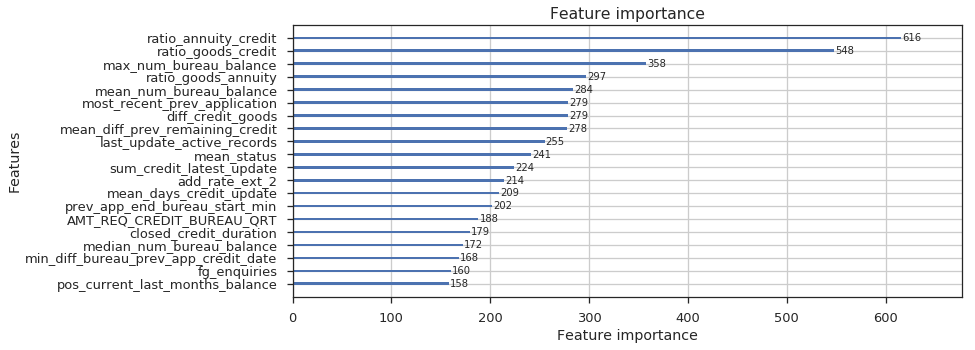

In [23]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='split', max_num_features=20, ax=ax);

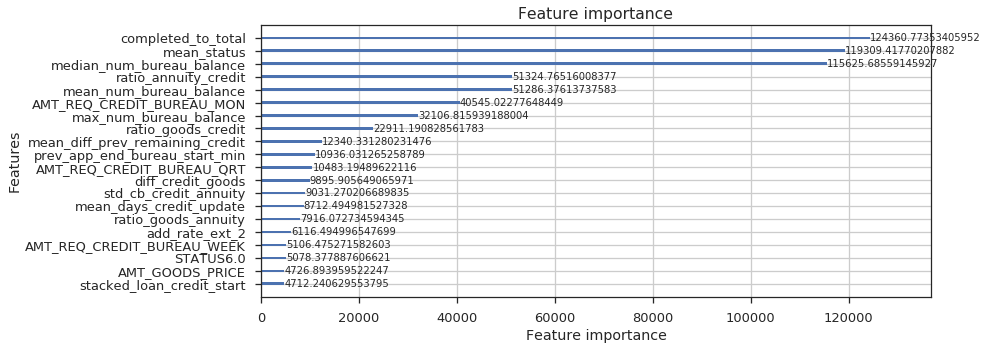

In [16]:
fig, ax = plt.subplots(1, figsize=(12, 5))
lgb.plot_importance(m, importance_type='gain', max_num_features=20, ax=ax);

### OOF prediction for training set

In [5]:
SKIP_FLDS = ['SK_ID_CURR', 'TARGET', 'is_test']

data['is_test'] = 1
data['is_test'].iloc[:303576] = 0

data  = data.sample(frac=1.) # shuffle rows
df, y = data.loc[:, data.columns.drop(SKIP_FLDS)], data.loc[:, 'is_test']

In [6]:
%%time

estimator  = lgb.LGBMClassifier(n_estimators=2015, max_depth=4, objective='binary')
oof_scores = cross_val_predict(estimator, df, y, cv=5, method='predict_proba')

CPU times: user 2h 51min 43s, sys: 22 s, total: 2h 52min 5s
Wall time: 44min 51s


In [7]:
np.save('../data/processed/models/oof_scores_sub.npy', oof_scores)

In [6]:
oof_scores = np.load('../data/processed/models/oof_scores.npy')

In [8]:
df_copy                        = df.copy()
df_copy.loc[:, 'is_test_prob'] = oof_scores[:, 1]
df_copy.loc[:, 'is_test']      = y
df_copy.loc[:, 'SK_ID_CURR']   = data.SK_ID_CURR

target                         = data.TARGET.iloc[:303576]

In [9]:
del data
gc.collect()

82

In [10]:
df_copy[df_copy.is_test == 0].sort_values(by='is_test_prob', ascending=False)\
                             .loc[:, ['SK_ID_CURR', 'is_test_prob']]

,SK_ID_CURR,is_test_prob
72358,185021,9.999868e-01
131849,254911,9.974637e-01
176317,307008,9.966514e-01
163651,292206,9.949051e-01
252925,396519,9.937778e-01
59929,170445,9.932063e-01
167459,296636,9.931919e-01
107132,225900,9.925747e-01
66538,178204,9.920861e-01
120631,241677,9.918937e-01


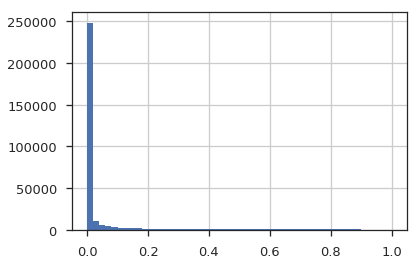

In [11]:
df_copy[df_copy.is_test == 0].is_test_prob.hist(bins=50);

In [77]:
def fold_gen(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .15)]

    for fold in range(5):
        test_index  = list(x.sample(frac=48744).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        yield train_index,  test_index

In [12]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .4)].shape[0]

12798

In [13]:
df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob <= 0.3)].shape[0]

286674

In [24]:
16668 / 307511

0.05420293908185398

In [26]:
.2 * 48744

9748.800000000001

In [20]:
def save_folds(df_copy):
    x = df_copy[(df_copy.is_test == 0) & (df_copy.is_test_prob > .3)]
    test_folds = []
    
    for fold in range(6):
        test_index  = list(x.sample(n=9748).index)
        train_index = list(set(df_copy[(df_copy.is_test == 0)].index) - set(test_index))

        test_folds.append(test_index)
    
    test_folds = np.array(test_folds).T
    cv_df      = pd.DataFrame(test_folds, columns=[f'F{i}' for i in range(6)])
    
    cv_df.to_csv('../data/raw/cv_adversarial_idx_sub_v1.csv', index=False)
#     return cv_df

In [34]:
save_folds(df_copy)

In [15]:
cv_folds = save_folds(df_copy)

In [16]:
len((set(cv_folds['F0'].values) & set(cv_folds['F2'].values))) / len(cv_folds['F0'])

0.5820681165367255

In [17]:
len((set(cv_folds['F0'].values) & set(cv_folds['F3'].values))) / len(cv_folds['F0'])

0.5770414443988511

In [32]:
len((set(cv_folds['F0'].values) & set(cv_folds['F4'].values))) / len(cv_folds['F0'])

0.5860689372178909

In [18]:
len((set(cv_folds['F0'].values) & set(cv_folds['F1'].values))) / len(cv_folds['F0'])

0.5798112433319655

In [19]:
df_copy.shape

(352321, 710)

In [82]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'seed': SEED
}

num_boost_round       = 500
early_stopping_rounds = 100

ltrain = lgb.Dataset(df.iloc[:len(train)].copy(), TARGET, feature_name=df.columns.tolist())

lgb.cv(params, 
       ltrain, 
       num_boost_round, 
       folds=fold_gen(df_copy), 
       early_stopping_rounds=early_stopping_rounds, 
       verbose_eval=20)

[20]	cv_agg's auc: 0.618144 + 0.00514626
[40]	cv_agg's auc: 0.631824 + 0.0046029
[60]	cv_agg's auc: 0.63968 + 0.00515748
[80]	cv_agg's auc: 0.64062 + 0.00485862
[100]	cv_agg's auc: 0.642104 + 0.00573209
[120]	cv_agg's auc: 0.642286 + 0.00572781
[140]	cv_agg's auc: 0.642618 + 0.00600976
[160]	cv_agg's auc: 0.642657 + 0.00613822
[180]	cv_agg's auc: 0.642169 + 0.0060855
[200]	cv_agg's auc: 0.64151 + 0.00599734
[220]	cv_agg's auc: 0.641801 + 0.0057658
[240]	cv_agg's auc: 0.642513 + 0.00623979
[260]	cv_agg's auc: 0.64221 + 0.00644424


{'auc-mean': [0.6042937582096902,
  0.6063851080102118,
  0.6094948735497355,
  0.6105071593059883,
  0.6103113565861819,
  0.609949146327001,
  0.6112450210864804,
  0.611922664355651,
  0.6130385780092173,
  0.6135514649349239,
  0.6140567851372335,
  0.6138722483547333,
  0.6138905358882123,
  0.6144706221804735,
  0.6154927026924676,
  0.6163287187043333,
  0.616554768416919,
  0.6173352621591126,
  0.6174060247445852,
  0.6181444201569033,
  0.6187143963227383,
  0.6194944579588235,
  0.6198957050849789,
  0.6207915448273522,
  0.6219778419869648,
  0.6230271612099727,
  0.6237795045767934,
  0.6248345699284803,
  0.6255729154444939,
  0.626186580135842,
  0.6268817748326054,
  0.6272010226809934,
  0.6273822084294582,
  0.6275895204726845,
  0.6282070344389259,
  0.6287205101248088,
  0.6293304442291344,
  0.6304520246260321,
  0.6314348211934767,
  0.63182393503278,
  0.6320910920507157,
  0.6328286905792679,
  0.6332499251145899,
  0.6335400030841262,
  0.6339219347473423,
  0.

## Feature Selection

### Shuffle target

In [9]:
%%time 

data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

# sample
# data     = data.iloc[:307511].sample(n=10000, random_state=SEED)

df, y     = data.loc[:, v86_feat], data.TARGET

# shuffle target variable
y = y.sample(frac=1.)


del data
gc.collect();

CPU times: user 4.46 s, sys: 1.17 s, total: 5.62 s
Wall time: 5.62 s


In [10]:
Xtr, Xte, ytr, yte = train_test_split(df, y, test_size=.2, random_state=SEED)

In [11]:
params = {
    'objective': 'binary',
    'learning_rate': 0.02,
    'metric': 'auc',
    'max_depth': 6,
    'sub_feature': .05,
    'reg_lambda': 100,
    'num_leaves': 30,
    'min_data_in_leaf': 100,
    'feature_fraction_seed': SEED,
    'min_data_in_leaf': 100,
    'max_bin': 300,
    'reg_lambda': 100,
    'nthread': 4,
    'verbose': -1,
    'seed': SEED
}

num_boost_round       = 10000
early_stopping_rounds = 100

ltrain = lgb.Dataset(Xtr, ytr, feature_name=Xtr.columns.tolist())
lval   = lgb.Dataset(Xte, yte, feature_name=Xte.columns.tolist())

val_sets  = [ltrain, lval]
val_names = ['train', 'eval'] 

m      = lgb.train(params, 
                   ltrain, 
                   num_boost_round, 
                   valid_sets=val_sets, 
                   valid_names=val_names, 
                   early_stopping_rounds=early_stopping_rounds,
                   verbose_eval=20
                  )

Training until validation scores don't improve for 100 rounds.
[20]	train's auc: 0.426591	eval's auc: 0.425956
[40]	train's auc: 0.426591	eval's auc: 0.425956
[60]	train's auc: 0.426591	eval's auc: 0.425956
[80]	train's auc: 0.426591	eval's auc: 0.425956
[100]	train's auc: 0.426591	eval's auc: 0.425956
Early stopping, best iteration is:
[1]	train's auc: 0.426591	eval's auc: 0.425956


In [12]:
feat_imp_shuffled = pd.DataFrame({
            'feat': m.feature_name(), 
            'imp': m.feature_importance(importance_type='gain')
})\
             .sort_values(by='imp', ascending=False)

In [13]:
feat_imp_shuffled

,feat,imp
0,LANDAREA_MEDI,0.0
383,max_credit_term,0.0
377,diff_occupation_days_birth_mean,0.0
378,annuity_sub_income_ext_source_2,0.0
379,NAME_FAMILY_STATUS,0.0
380,STATUS2.0,0.0
381,max_overdue_credit_median,0.0
382,income_education,0.0
384,diff_code_gender_occupation_source_2_mean,0.0
375,max_num_bureau_balance,0.0


## Bayesian Optimization

In [13]:
%%time

data = pd.read_hdf('../data/interim/dataset5/data.h5', key='data')
features = np.load('../data/interim/dataset5/v89_features.npy')
data  = data.iloc[:307511]

# create sample
# data  = data.sample(n=1000)

df, y = data.loc[:, features], data.TARGET

del data
gc.collect();

CPU times: user 6.47 s, sys: 1.6 s, total: 8.07 s
Wall time: 8.08 s


### LGB

In [4]:
def bayes_parameter_opt_lgb(X, y, init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=6,
                            n_estimators=50000, 
                            learning_rate=0.01, 
                            output_process=False):
    
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    
    # parameters
    def lgb_eval(num_leaves, 
                 feature_fraction, 
                 bagging_fraction, 
                 max_depth, 
                 lambda_l1, 
                 lambda_l2, 
                 min_split_gain, 
                 min_child_weight,
                 min_data_in_leaf
                ):
        
        params = {'application':'binary',
                  'num_iterations': n_estimators, 
                  'learning_rate':learning_rate, 
                  'early_stopping_round':200,
                  'metric':'auc',
                  'seed': 4457
                 }
        
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['bagging_seed'] = params['seed']
        params['feature_fraction_seed'] = params['seed']
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        
        def get_folds(X, cv_df):
            FOLD_NUM = [0, 2, 3, 4, 5]

            for fold in FOLD_NUM:
                test_idx  = list(cv_df[f'F{fold}'].values)
                train_idx = list(set(X.index) - set(test_idx))

                yield train_idx, test_idx

        
        cv_df     = pd.read_csv('../data/raw/cv_adversarial_idx_v1.csv')
        cv_result = lgb.cv(params, 
                           train_data, 
                           folds=get_folds(X, cv_df), 
                           seed=random_seed, 
                           verbose_eval=200, 
                           metrics=['auc'])
        
        return max(cv_result['auc-mean'])
    
    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (10, 100),
                                            'feature_fraction': (0.01, 1),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (4, 9),
                                            'lambda_l1': (0, 100),
                                            'lambda_l2': (0, 200),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (1, 200),
                                            'min_data_in_leaf': (20, 300)
                                           }, random_state=0)
    
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res['max']['max_params']

In [5]:
opt_params = bayes_parameter_opt_lgb(df, 
                                     y, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=5, 
                                     random_seed=4457, 
                                     n_estimators=50000, 
                                     learning_rate=0.01)

Initialization
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   bagging_fraction |   feature_fraction |   lambda_l1 |   lambda_l2 |   max_depth |   min_child_weight |   min_data_in_leaf |   min_split_gain |   num_leaves | 
[200]	cv_agg's auc: 0.744739 + 0.0122541
[400]	cv_agg's auc: 0.759323 + 0.0119972
[600]	cv_agg's auc: 0.767049 + 0.0115447
[800]	cv_agg's auc: 0.771988 + 0.0110609
[1000]	cv_agg's auc: 0.774993 + 0.0109011
[1200]	cv_agg's auc: 0.777233 + 0.0107943
[1400]	cv_agg's auc: 0.779233 + 0.0106538
[1600]	cv_agg's auc: 0.780913 + 0.0105478
[1800]	cv_agg's auc: 0.782181 + 0.0104106
[2000]	cv_agg's auc: 0.783307 + 0.0103566
[2200]	cv_agg's auc: 0.784242 + 0.0102572
[2400]	cv_agg's auc: 0.785006 + 0.0101904
[2600]	cv_agg's auc: 0.785659 + 0.0101055
[2800]	cv_agg's auc: 0.786207 + 0.0100303
[3000]	cv_agg's auc:

KeyboardInterrupt: 

In [ ]:
opt_params

In [8]:
opt_params

{'num_leaves': 90.1038886747769,
 'feature_fraction': 0.25922779025993026,
 'bagging_fraction': 0.8545401681825219,
 'max_depth': 8.36120043475591,
 'lambda_l1': 1.2905881944748177,
 'lambda_l2': 99.31304247302758,
 'min_split_gain': 0.006678387645986113,
 'min_child_weight': 84.50339511445843,
 'min_data_in_leaf': 199.16211041831193}

In [30]:
opt_params

{'num_leaves': 58.90115643923338,
 'feature_fraction': 0.10365793567780747,
 'bagging_fraction': 0.8973031258439608,
 'max_depth': 4.023325017204941,
 'lambda_l1': 0.09769178929222022,
 'lambda_l2': 51.347676077479576,
 'min_split_gain': 0.0568555464713031,
 'min_child_weight': 77.39510611656549,
 'min_data_in_leaf': 57.52765760435166}

### XGB

In [14]:
def bayes_parameter_opt_xgb(X, y, init_round=15, 
                            opt_round=25, 
                            n_folds=5, 
                            random_seed=6,
                            n_estimators=50000, 
                            learning_rate=0.03, 
                            output_process=False):
    
    # prepare data
    train_data = xgb.DMatrix(data=X, label=y)
    
    # parameters
    def xgb_eval(max_depth, 
                 colsample_bytree, 
                 colsample_bylevel,
                 subsample,
                 gamma, 
                 min_child_weight
                ):
        
        params = {'objective': 'binary:logistic',
                  'num_iterations': n_estimators, 
                  'eta':learning_rate, 
                  'early_stopping_round':200,
                  'eval_metric':'auc',
                  'seed': 4457
                 }
        
        params['max_depth'] = int(round(max_depth))
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['colsample_bylevel'] = max(min(colsample_bylevel, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['gamma'] = int(round(gamma))
        params['min_child_weight'] = int(round(min_child_weight))
        
        def get_folds(X, cv_df):
            FOLD_NUM = [0, 2, 3, 4, 5]

            for fold in FOLD_NUM:
                test_idx  = list(cv_df[f'F{fold}'].values)
                train_idx = list(set(X.index) - set(test_idx))

                yield train_idx, test_idx

        
#         cv_df     = pd.read_csv('../data/raw/cv_adversarial_idx_v1.csv')
        cv_result = xgb.cv(params, 
                           train_data, 
                           folds=5, 
                           seed=random_seed, 
                           verbose_eval=200, 
                           metrics=['auc'])
        
        return max(cv_result['test-auc-mean'])
    
    # range 
    xgbBO = BayesianOptimization(xgb_eval, {'max_depth': (2, 9),
                                            'colsample_bytree': (0.01, 1),
                                            'colsample_bylevel': (0.01, 1),
                                            'subsample': (.6, 1.),
                                            'gamma': (0, 20),
                                            'min_child_weight': (1, 200)
                                           }, random_state=0)
    
    # optimize
    xgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: xgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return xgbBO.res['max']['max_params']

In [ ]:
opt_params = bayes_parameter_opt_xgb(df, 
                                     y, 
                                     init_round=5, 
                                     opt_round=10, 
                                     n_folds=5, 
                                     random_seed=4457, 
                                     n_estimators=50000, 
                                     learning_rate=0.03)

Initialization
-------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bylevel |   colsample_bytree |     gamma |   max_depth |   min_child_weight |   subsample | 
[0]	train-auc:0.716633+0.00498025	test-auc:0.71236+0.00715286


In [ ]:
opt_params

## Model Prediction Analysis

```
- Look at prediction of model
- Look for examples where it has performed poorly.
- Analyze those examples to find any patterns.
```

In [3]:
# load predictions of best model so far

train = pd.read_pickle('../data/interim/feature_groups/application_train.pkl')
preds = np.load('../data/interim/dataset6/v123_4457_oof_train_preds.npy')
true  = train.TARGET.values

In [9]:
train.loc[:, 'preds'] = preds[:, 0]

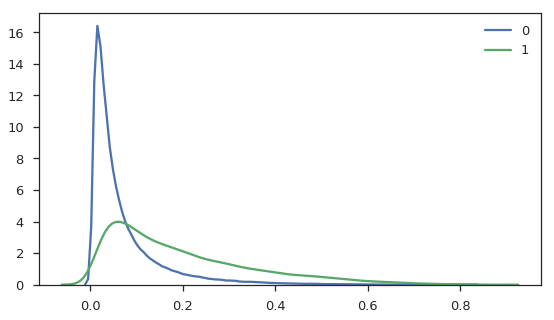

In [12]:
plt.figure(figsize=(9, 5))

sns.kdeplot(train[train.TARGET == 0].preds, label='0')
sns.kdeplot(train[train.TARGET == 1].preds, label='1');

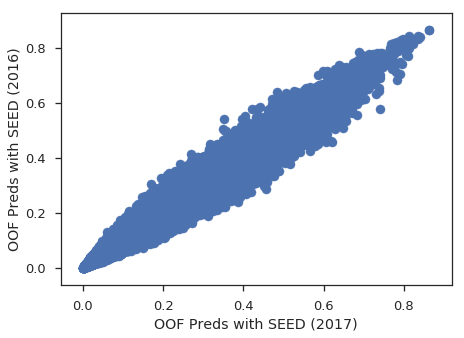

In [16]:
plt.figure(figsize=(7, 5))
plt.scatter(preds[:, 0], preds[:, 1])
plt.xlabel('OOF Preds with SEED (2017)')
plt.ylabel('OOF Preds with SEED (2016)');

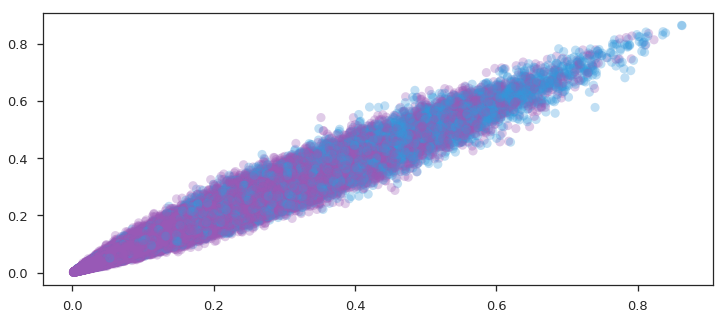

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.regplot(x=preds[:, 0], 
            y=preds[:, 1], 
            fit_reg=False, 
            ax=ax,
            scatter_kws={'alpha': .3, 'facecolors': np.where( train.TARGET==0 , "#9b59b6", "#3498db")}
          );

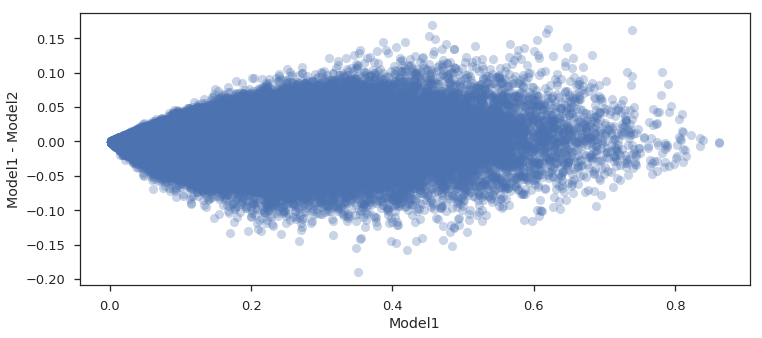

In [34]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.regplot(x=preds[:, 0], 
            y=preds[:, 0] - preds[:, 1], 
            fit_reg=False, 
            ax=ax,
            scatter_kws={'alpha': .3}
          )
ax.set_xlabel('Model1')
ax.set_ylabel('Model1 - Model2');

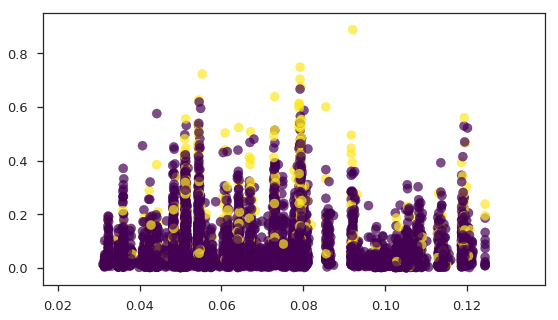

In [14]:
plt.figure(figsize=(9, 5))aa
plt.scatter(df.AMT_ANNUITY / df.AMT_CREDIT, df.preds, c=df.target, cmap='viridis', alpha=.7);

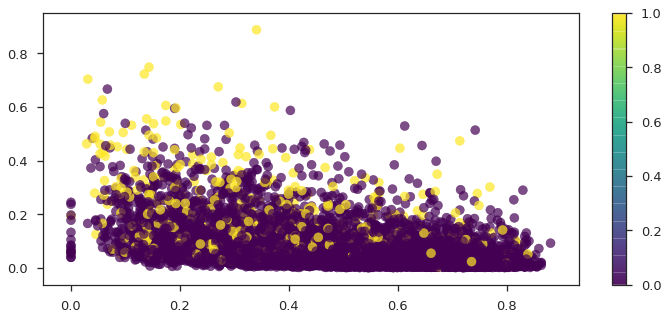

In [20]:
plt.figure(figsize=(12, 5))
plt.scatter((df.EXT_SOURCE_3), df.preds, c=df.target, cmap='viridis', alpha=.7)
plt.colorbar();

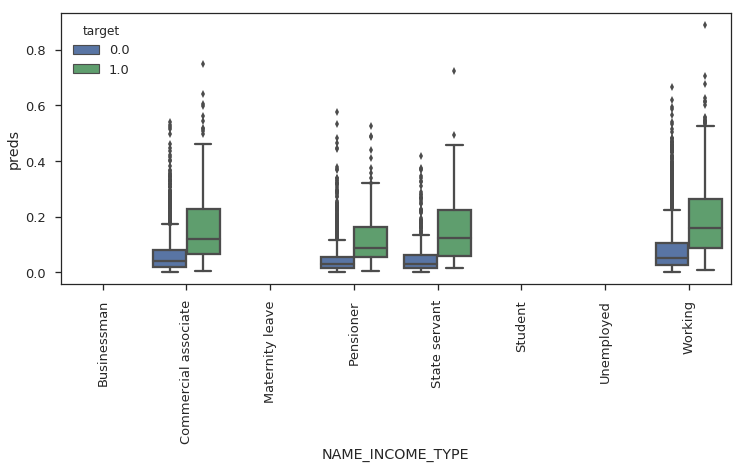

In [9]:
plt.figure(figsize=(12, 5))
sns.boxplot(x=df.NAME_INCOME_TYPE, y=df.preds, hue=df.target)
plt.xticks(rotation=90);

## Correlated features

In [3]:
data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

In [12]:
%%time

corr = data.loc[:, list(v86_feat) + ['TARGET']].iloc[:307511].corr()

CPU times: user 6min 17s, sys: 752 ms, total: 6min 18s
Wall time: 6min 18s


In [14]:
corr.to_csv('../data/tmp/corr.csv', index=True)

## OOF Preds

In [39]:
%%time 

data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

# sample
data     = data.iloc[:307511].sample(n=5000, random_state=SEED)
df, y     = data.loc[:, v86_feat], data.TARGET

del data
gc.collect();

CPU times: user 4.44 s, sys: 1.05 s, total: 5.48 s
Wall time: 5.49 s


In [71]:
Xtr, Xte, ytr, yte = train_test_split(df, y, test_size=.2, random_state=SEED)

In [72]:
m = xgb.XGBClassifier(objective='binary:logistic',
                       max_depth=4,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       gamma=5,
                       n_jobs=-1,
                       random_state=SEED
                      )


cv        = KFold(n_splits=5, shuffle=True, random_state=SEED)
oof_preds = cross_val_predict(m, Xtr, ytr, method='predict_proba', cv=cv)

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

In [73]:
# without new features score on holdout set

m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, val_preds)

0.7346603260869566

In [74]:
Xtr.loc[:, 'ratio_ext_source_1_preds'] = Xtr['EXT_SOURCE_1'] / oof_preds[:, 1]
Xtr.loc[:, 'ratio_ext_source_2_preds'] = Xtr['EXT_SOURCE_2'] / oof_preds[:, 1]
Xtr.loc[:, 'ratio_ext_source_3_preds'] = Xtr['EXT_SOURCE_3'] / oof_preds[:, 1]

Xtr.loc[:, 'diff_ext_source_1_preds'] = Xtr['EXT_SOURCE_1'] - oof_preds[:, 1]
Xtr.loc[:, 'diff_ext_source_2_preds'] = Xtr['EXT_SOURCE_2'] - oof_preds[:, 1]
Xtr.loc[:, 'diff_ext_source_3_preds'] = Xtr['EXT_SOURCE_3'] - oof_preds[:, 1]

In [75]:
Xte.loc[:, 'ratio_ext_source_1_preds'] = Xte['EXT_SOURCE_1'] / val_preds
Xte.loc[:, 'ratio_ext_source_2_preds'] = Xte['EXT_SOURCE_2'] / val_preds
Xte.loc[:, 'ratio_ext_source_3_preds'] = Xte['EXT_SOURCE_3'] / val_preds

Xte.loc[:, 'diff_ext_source_1_preds'] = Xte['EXT_SOURCE_1'] - val_preds
Xte.loc[:, 'diff_ext_source_2_preds'] = Xte['EXT_SOURCE_2'] - val_preds
Xte.loc[:, 'diff_ext_source_3_preds'] = Xte['EXT_SOURCE_3'] - val_preds

In [76]:
m.fit(Xtr, ytr)
new_val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, new_val_preds)

0.7126630434782609

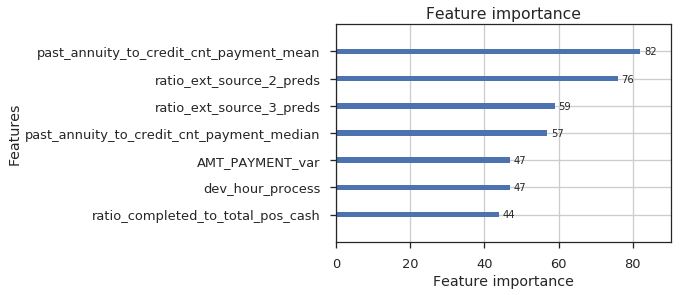

In [77]:
lgb.plot_importance(m.booster_, max_num_features=7)

## XGBoost Leaves

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [59]:
class XGBoostLeaves(BaseEstimator, ClassifierMixin):
    params = {
        'objective': 'binary:logistic',
        'eta': .01,
        'max_depth': 2,
        'colsample_bytree': .1,
        'min_child_weight': 20,
        'gamma': 5,
        'nthread': 4,
        'silent': 1
    }

    def __init__(self, num_leaves):
        self.num_leaves = num_leaves

    def fit(self, X, y=None):
        dtrain     = xgb.DMatrix(X, y)
        self.model = xgb.train(self.params, dtrain, self.num_leaves)

    def predict(self, X):
        return self.model.predict(xgb.DMatrix(X), pred_leaf=True)

In [60]:
%%time 

data     = pd.read_hdf('../data/interim/dataset2/data.h5', key='data')
v86_feat = np.load('../data/interim/dataset2/v86_features.npy')

# sample
data     = data.iloc[:307511].sample(n=5000, random_state=SEED)
df, y     = data.loc[:, v86_feat], data.TARGET

del data
gc.collect();

CPU times: user 4.56 s, sys: 1.05 s, total: 5.61 s
Wall time: 5.61 s


In [61]:
# split into training and test set
Xtr, Xte, ytr, yte = train_test_split(df, y, test_size=.2, random_state=SEED)

In [62]:
%%time

num_leaves = 20
fte        = XGBoostLeaves(num_leaves)
train_fte  = cross_val_predict(fte, Xtr, ytr, cv=3)

fte.fit(Xtr, ytr)
test_fte  = fte.predict(Xte)

CPU times: user 1.84 s, sys: 3.74 ms, total: 1.84 s
Wall time: 650 ms


In [63]:
# without leaves from XGBoost

m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

roc_auc_score(yte, val_preds)

0.7346603260869566

In [64]:
train_fte_df = pd.DataFrame(train_fte, columns=[f'leaf_{i}' for i in range(train_fte.shape[1])])
train_fte_df.index = Xtr.index

test_fte_df = pd.DataFrame(test_fte, columns=[f'leaf_{i}' for i in range(test_fte.shape[1])])
test_fte_df.index = Xte.index

Xtr_new      = pd.concat((Xtr, train_fte_df), axis=1)
Xte_new      = pd.concat((Xte, test_fte_df), axis=1)

In [65]:
m = lgb.LGBMClassifier(objective='binary',
                       max_depth=4,
                       num_leaves=15,
                       n_estimators=800, 
                       learning_rate=.1, 
                       colsample_bytree=.1, 
                       reg_lambda=20,
                       min_child_weight=10,
                       random_state=SEED
                      )

m.fit(Xtr_new, ytr)
val_preds = m.predict_proba(Xte_new)[:, 1]

roc_auc_score(yte, val_preds)

0.7244429347826087

In [51]:
feat_df.loc[feat_df.feat.isin([c for c in feat_df.feat if 'leaf_' in c])]

,feat,imp
571,leaf_0,3
572,leaf_1,2
573,leaf_2,2
574,leaf_3,2
575,leaf_4,1
576,leaf_5,3
577,leaf_6,3
578,leaf_7,1
579,leaf_8,6
580,leaf_9,7


In [35]:
feat_df = pd.DataFrame({'feat': Xtr_new.columns, 'imp': m.feature_importances_})
feat_df.sort_values(by='imp', ascending=False)

,feat,imp
21,past_annuity_to_credit_cnt_payment_mean,69
131,dev_hour_process,55
369,past_annuity_to_credit_cnt_payment_median,53
409,CNT_INSTALMENT_FUTURE_sum,49
109,pca_0,49
293,ratio_age_employed,45
203,region_ext_source_3,44
267,diff_reg_age,42
346,ratio_completed_to_total_pos_cash,40
450,closed_credit_duration,39


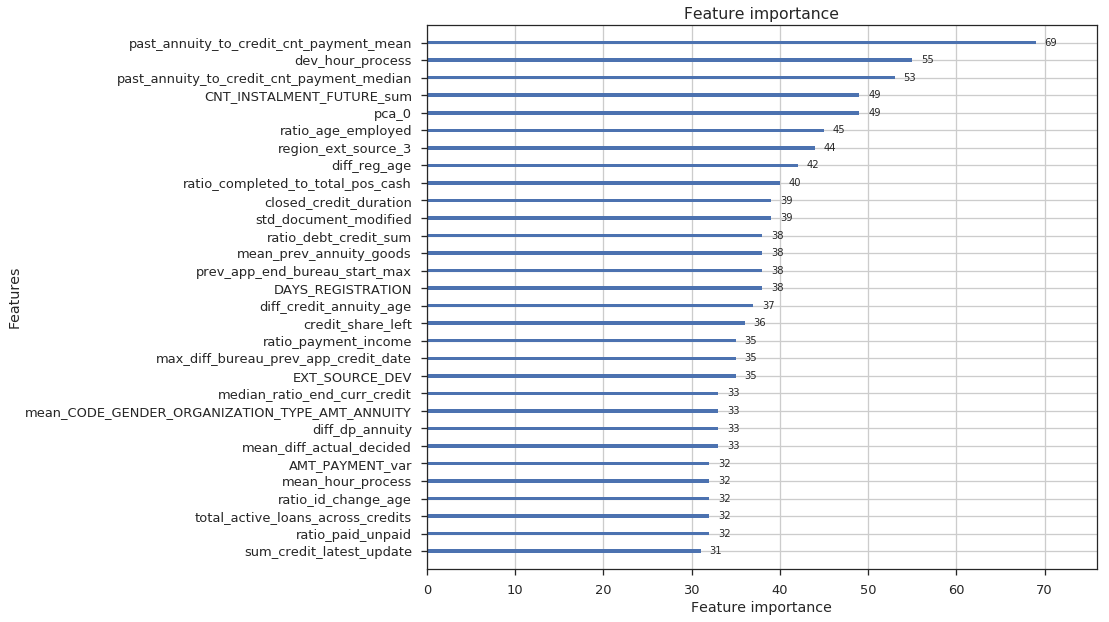

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))
lgb.plot_importance(m.booster_, max_num_features=30, ax=ax);

## Stacking

In [3]:
!ls ../data/oof_sub/

target.npy		 v95_4457_oof_preds.npy  v98_4457_oof_preds.npy
v101_4457_oof_preds.npy  v96_4457_oof_preds.npy  v99_4457_oof_preds.npy


In [14]:
v95_oof_preds  = np.load('../data/oof_sub/v95_4457_oof_preds.npy')
v96_oof_preds  = np.load('../data/oof_sub/v96_4457_oof_preds.npy')
v98_oof_preds  = np.load('../data/oof_sub/v98_4457_oof_preds.npy')
v99_oof_preds  = np.load('../data/oof_sub/v99_4457_oof_preds.npy')
v101_oof_preds = np.load('../data/oof_sub/v101_4457_oof_preds.npy')
v103_oof_preds = np.load('../data/oof_sub/v103_4457_oof_preds.npy')

target        = np.load('../data/oof_sub/target.npy')

In [15]:
# individual auc
print(roc_auc_score(target, v95_oof_preds))
print(roc_auc_score(target, v96_oof_preds))
print(roc_auc_score(target, v98_oof_preds))
print(roc_auc_score(target, v99_oof_preds))
print(roc_auc_score(target, v101_oof_preds))
print(roc_auc_score(target, v103_oof_preds))

0.7969094013755929
0.796351720200634
0.797149124049181
0.7971562952226112
0.7964111070639521
0.7445130003399485


In [16]:
pd.DataFrame({'v95': v95_oof_preds,
              'v96': v96_oof_preds,
              'v98': v98_oof_preds,
              'v99': v99_oof_preds,
              'v101': v101_oof_preds,
              'v103': v103_oof_preds
             }).corr()

,v95,v96,v98,v99,v101,v103
v95,1.000000,0.990502,0.996513,0.996373,0.996575,0.786498
v96,0.990502,1.000000,0.989902,0.989738,0.990057,0.777203
v98,0.996513,0.989902,1.000000,0.997178,0.995720,0.782476
v99,0.996373,0.989738,0.997178,1.000000,0.995579,0.781733
v101,0.996575,0.990057,0.995720,0.995579,1.000000,0.787711
v103,0.786498,0.777203,0.782476,0.781733,0.787711,1.000000


In [17]:
X = np.hstack((v95_oof_preds[:, None], 
               v96_oof_preds[:, None],
               v98_oof_preds[:, None],
               v99_oof_preds[:, None],
               v101_oof_preds[:, None],
               v103_oof_preds[:, None]
              ))
y = target

In [18]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=.3, random_state=SEED)

In [26]:
m = xgb.XGBClassifier(n_estimators=150, 
                      max_depth=2, 
                      learning_rate=.03,
                      min_child_weight=20,
                      gamma=1,
                      n_jobs=4, 
                      seed=SEED)

# m = LogisticRegression(C=10, random_state=SEED, n_jobs=-1)
m.fit(Xtr, ytr)
val_preds = m.predict_proba(Xte)[:, 1]

print('ROC_AUC Score: {}'.format(roc_auc_score(yte, val_preds)))

ROC_AUC Score: 0.7939366736902169


In [29]:
m = xgb.XGBClassifier(n_estimators=150, 
                      max_depth=2, 
                      learning_rate=.06, 
                      min_child_weight=5, 
                      n_jobs=4, 
                      seed=SEED)

m.fit(X, y)
val_preds = m.predict_proba(X)[:, 1]

print('ROC_AUC Score: {}'.format(roc_auc_score(y, val_preds)))

ROC_AUC Score: 0.7981012758354703


## Cross-validation indices

In [4]:
%time data = pd.read_csv('../data/raw/application_train.csv.zip')

CPU times: user 4.97 s, sys: 328 ms, total: 5.3 s
Wall time: 7.74 s


In [22]:
skf = KFold(n_splits=5, shuffle=True, random_state=SEED)

te_indices = []

for (itr, ite) in skf.split(data, data.TARGET):
    te_indices.append(ite)

In [18]:
cv_df = pd.DataFrame({
    'F0': te_indices[0][:-1],
    'F1': te_indices[1],
    'F2': te_indices[2],
    'F3': te_indices[3],
    'F4': te_indices[4]
})

In [21]:
cv_df.to_csv('../data/raw/cv_idx_test_stratified.csv', index=False)